In [3]:
import numpy as np
import pandas as pd
import nltk
from transformers import pipeline
from datasets import load_dataset

In [4]:
# Load a Dataset from Hugging Face
dataset = load_dataset("cnn_dailymail", "3.0.0", split="test[:1000]")

# Define Pre-Trained Summarization Models
summarization_models = {
    "M1": "facebook/bart-large-cnn",
    "M2":  "t5-small",
    "M3": "Falconsai/text_summarization",
    "M4": "sshleifer/distilbart-cnn-12-6"
}

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

C:\Users\Asus\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asus\.cache\huggingface\hub\datasets--cnn_dailymail. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [5]:
# Function to Summarize Text
def summarize_text(model_name, text):
    summarizer = pipeline("summarization", model=summarization_models[model_name])
    summary = summarizer(text, max_length=150, min_length=50, do_sample=False, truncation=True)
    return summary[0]["summary_text"]

In [6]:
!pip install rouge

In [7]:
from rouge import Rouge
rouge = Rouge()
# Function to Evaluate Summary
def evaluate_summary(original_text, summary_text):
    result = rouge.get_scores(hyps=[summary_text], refs=[original_text])[0]
    return {
        "P1": result["rouge-1"]["f"],  # ROUGE-1
        "P2": result["rouge-2"]["f"],  # ROUGE-2
        "P3": result["rouge-l"]["f"],  # ROUGE-L
        "P4": len(summary_text) / len(original_text)  # Compression Ratio
    }

In [8]:
def apply_topsis(models, data):
    data = np.array(data)  # Convert list of lists to NumPy array
    weights = np.array([0.4, 0.3, 0.2, 0.1])  # Importance of each criterion
    impacts = np.array(["+", "+", "+", "-"])  # Higher is better for ROUGE; lower for Compression

    # Normalize the decision matrix
    norm_data = data / np.sqrt((data ** 2).sum(axis=0))

    # Calculate weighted normalized decision matrix
    weighted_data = norm_data * weights

    # Identify ideal best and worst solutions
    ideal_best = np.where(impacts == "+", weighted_data.max(axis=0), weighted_data.min(axis=0))
    ideal_worst = np.where(impacts == "+", weighted_data.min(axis=0), weighted_data.max(axis=0))
    # Calculate distances from ideal best and worst
    distance_best = np.sqrt(((weighted_data - ideal_best) ** 2).sum(axis=1))
    distance_worst = np.sqrt(((weighted_data - ideal_worst) ** 2).sum(axis=1))

    # Calculate TOPSIS scores
    topsis_scores = distance_worst / (distance_best + distance_worst)

    # Rank the models
    ranks = topsis_scores.argsort()[::-1] + 1  # Higher score = better rank

    return topsis_scores, ranks


In [9]:
results = []

# Process 5 random texts
for i in range(5):
    sample = dataset[i]
    text = sample["article"]
    reference_summary = sample["highlights"]
    evaluation_data = []
    model_names = []

    for model in summarization_models.keys():
        summary = summarize_text(model, text)
        metrics = evaluate_summary(reference_summary, summary)
        evaluation_data.append(list(metrics.values()))
        model_names.append(model)

    topsis_scores,ranks = apply_topsis(model_names, evaluation_data)

    for j, model in enumerate(model_names):
        results.append([f"T{i+1}", model, *evaluation_data[j], topsis_scores[j], ranks[j]])

# Convert results to DataFrame
df_results = pd.DataFrame(results, columns=["Text", "Model", "P1", "P2", "P3", "P4", "Topsis Score", "Rank"])

# Print results
print(df_results)

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

C:\Users\Asus\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asus\.cache\huggingface\hub\models--facebook--bart-large-cnn. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined m

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

C:\Users\Asus\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asus\.cache\huggingface\hub\models--t5-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

C:\Users\Asus\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asus\.cache\huggingface\hub\models--Falconsai--text_summarization. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

C:\Users\Asus\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asus\.cache\huggingface\hub\models--sshleifer--distilbart-cnn-12-6. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cpu
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Device set to use cpu
Device set to use cpu
Device set to use cpu


   Text Model        P1        P2        P3        P4  Topsis Score  Rank
0    T1    M1  0.416667  0.289157  0.416667  1.476395      0.777348     4
1    T1    M2  0.281250  0.189189  0.281250  1.330472      0.161072     1
2    T1    M3  0.260870  0.151899  0.260870  1.296137      0.039464     2
3    T1    M4  0.468750  0.315789  0.468750  1.334764      0.991277     3
4    T2    M1  0.375000  0.253165  0.375000  1.028037      0.951519     1
5    T2    M2  0.317460  0.055556  0.317460  0.789720      0.135911     4
6    T2    M3  0.301370  0.046512  0.273973  1.158879      0.038396     2
7    T2    M4  0.368421  0.147368  0.315789  1.345794      0.496903     3
8    T3    M1  0.338028  0.150000  0.338028  1.311927      0.979291     4
9    T3    M2  0.084507  0.026667  0.084507  1.220183      0.013459     1
10   T3    M3  0.208955  0.084507  0.208955  1.169725      0.483237     3
11   T3    M4  0.338028  0.150000  0.338028  1.307339      0.979946     2
12   T4    M1  0.305556  0.121951  0.2

In [10]:
df_results.to_csv("summarization_results.csv", index=False)

Overall Best Model: M2 - t5-small


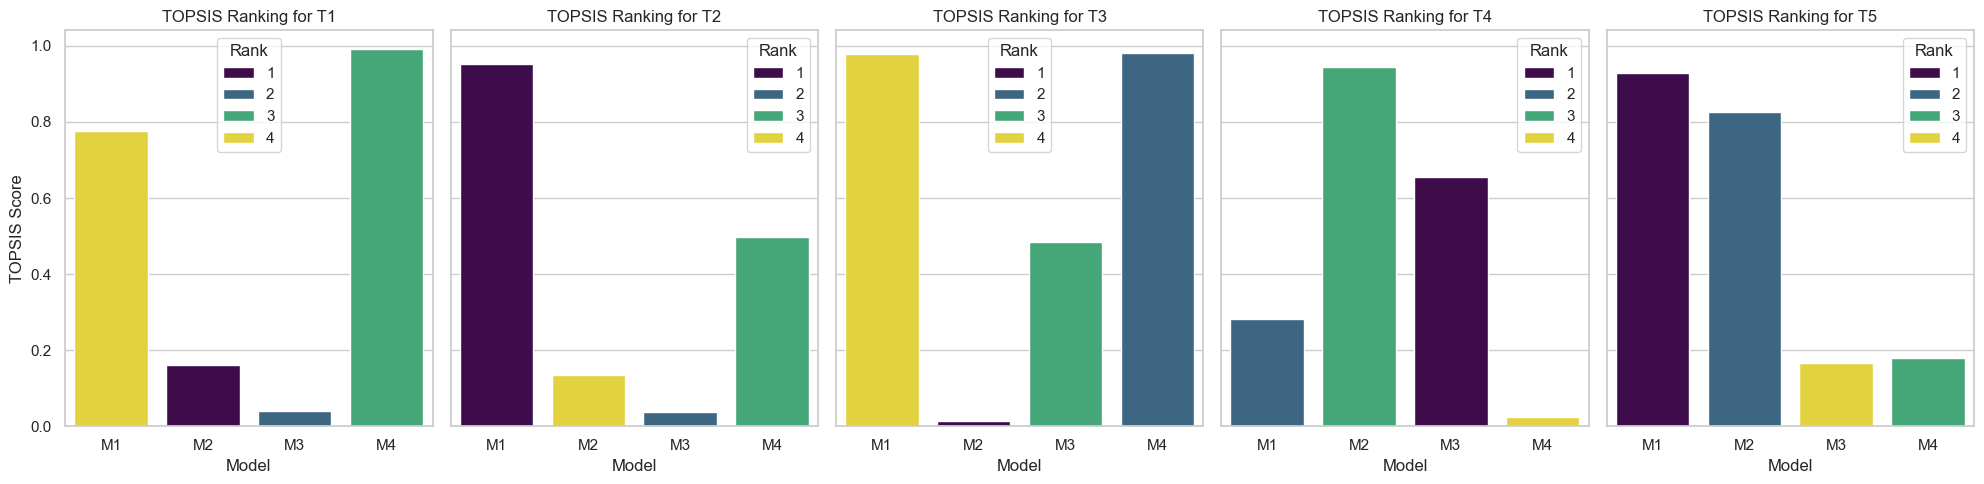

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

texts = df_results["Text"].unique()

for i, text in enumerate(texts):
    ax = axes[i]
    df_subset = df_results[df_results["Text"] == text]
    
    sns.barplot(x="Model", y="Topsis Score", data=df_subset, palette="viridis", ax=ax, hue="Rank", dodge=False)
    ax.set_title(f"TOPSIS Ranking for {text}")
    ax.set_xlabel("Model")
    ax.set_ylabel("TOPSIS Score" if i == 0 else "")
    ax.legend(title="Rank")

# Find the overall best model
rank1_counts = df_results[df_results["Rank"] == 1]["Model"].value_counts()
best_model_id = rank1_counts.idxmax()  # Model identifier (e.g., "M1")

# Dictionary mapping model IDs to full model names
summarization_models = {
    "M1": "facebook/bart-large-cnn",
    "M2": "t5-small",
    "M3": "Falconsai/text_summarization",
    "M4": "sshleifer/distilbart-cnn-12-6"
}

# Get the full model name
best_model_name = summarization_models[best_model_id]

# Print results
print(f"Overall Best Model: {best_model_id} - {best_model_name}")

# Show the plot
plt.tight_layout()
plt.show()